<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Импорт-библиотек-и-инструментов" data-toc-modified-id="Импорт-библиотек-и-инструментов-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Импорт библиотек и инструментов</a></span></li><li><span><a href="#Изучение-исходных-данных" data-toc-modified-id="Изучение-исходных-данных-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Изучение исходных данных</a></span></li><li><span><a href="#Сбалансированность-данных" data-toc-modified-id="Сбалансированность-данных-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Сбалансированность данных</a></span></li><li><span><a href="#Предобработка-текста" data-toc-modified-id="Предобработка-текста-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Предобработка текста</a></span></li><li><span><a href="#Подготовка-данных-к-обучению-моделей" data-toc-modified-id="Подготовка-данных-к-обучению-моделей-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Подготовка данных к обучению моделей</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#LogisticRegression" data-toc-modified-id="LogisticRegression-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>LogisticRegression</a></span></li><li><span><a href="#RandomForestClassifier" data-toc-modified-id="RandomForestClassifier-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>RandomForestClassifier</a></span></li><li><span><a href="#CatBoostClassifier" data-toc-modified-id="CatBoostClassifier-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>CatBoostClassifier</a></span></li><li><span><a href="#SGDClassifier" data-toc-modified-id="SGDClassifier-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>SGDClassifier</a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

### Импорт библиотек и инструментов

In [56]:
# библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import lightgbm as lgb
import time
import re 
import nltk
from tqdm import tqdm

# инструменты
from sklearn.utils import resample
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import GridSearchCV 
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import make_scorer
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import RandomizedSearchCV
from nltk.stem import WordNetLemmatizer 
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
from lightgbm import LGBMClassifier

# блокиратор предупреждений
import warnings
warnings.filterwarnings("ignore")

### Изучение исходных данных

In [57]:
data = pd.read_csv('/datasets/toxic_comments.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


In [58]:
pd.options.display.max_colwidth = 500 # увеличим количество выводимых символов в ячейках
data.sample(10)

,text,toxic
112393,"""\n\n Comment on Seregain \n\nActually, I was never almost blocked for my behavior. If you'll read the past AN/I incident, a user (Coldplay Expert) proposed a malformed """"topic ban"""" after the issue had already been resolved (which Jclemens corrected him on). He apologized afterwards\n\nIn the past AFD, I addressed each of Seregain's allegations individually and proved that most of them were lies or misunderstandings, and also provided a series of links which show that he is a likely banned ...",0
129219,Hey you! \n\nI LOVE BLACK PEOPLE!!!,0
12619,Hey! \n\nHello. My name is anon. Don't fuck with 4chan. Because we will take you down. Consider yourself warned.,1
156011,"""\n\n Are you seriously fact-checking a comedy movie? Btw, the stats are correct. 24% is about the average overhead for private insurance companies, while Medicare has around a 3% overhead. For the private insurance companies, it's not just """"for services,"""" but for things such as CEO pay and advertising.""",0
137005,"""\n If I were trying to post under an IP and a user name as a sock puppet, why in God's name would I IMMEDIATELY post, after using the IP, """"Whoops - sorry, forgot to log in"""" and identify myself? Isn't that specifically the effort of someone trying NOT to be considered a sock puppet (which is why I did it)? Based on the remarkable speed with which this block was begun and completed, I assert that jossi and shem got together and said, """"Let's work together and remove this person so that w...",0
85351,penish \n\nSNOOPING AS USUAL I SEEEEEEEEEEEEEEEEE,1
53305,Expansion \n\nI thought someone of Timman's stature deserved a more substantial article so I've used the Dutch version to expand it. Of course it needs references so any help here would be appreciated.,0
88667,"Dear Liberal Kook aka Respected Wikipedian \n\n I thought you Dummkopfs...er...I mean...Solar System Exploration Physicists...would be encouraged to know how WELL my PHASE II- STOP THE FUNDING plan has worked in forcing Wikipedia to change. \n\nSee the link below:\n\nhttp://wikipediaclassaction.org/\n\nYours Truly,\n\nBig Daddy\n\nps I told you it wasn't nice to be mean to Big Daddy...",0
79405,"""== Sources ==\n \n \n """,0
16594,This but a flesh wound,0


### Сбалансированность данных

<AxesSubplot:>

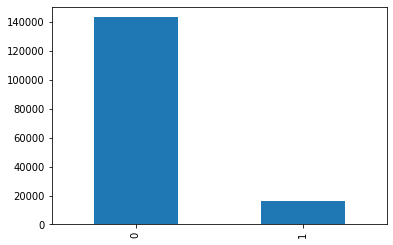

In [59]:
data['toxic'].value_counts().plot(kind='bar')

Наблюдается ярко выраженный дисбаланс классов, что следует учесть при обучении модели.

### Предобработка текста

Приведем текст к нижнему регистру:

In [62]:
data['text'] = data['text'].str.lower()

Очистим текст от лишних символов:

In [63]:
def clear_text(text):
    clear_list = re.sub(r'[^a-zA-Z ]', ' ', text)
    clear_text = " ".join(clear_list.split())
    return clear_text

data['text'] = data['text'].apply(clear_text)

Лемматизируем текст с помощью библиотеки WordNet:

In [64]:
m = WordNetLemmatizer()

def lemmatize(text):
    word_list = nltk.word_tokenize(text)
    lemm_list = [m.lemmatize(w) for w in word_list]
    lemm_text = " ".join(lemm_list)
    return lemm_text

data['text'] = data['text'].apply(lemmatize)

Проверим на явные дубликаты и избавимся от них при наличии:

In [65]:
print("Количество дубликатов до обработки:", data.duplicated().sum())
data.drop_duplicates(inplace=True)
print("Количество дубликатов после обработки:", data.duplicated().sum())

Количество дубликатов до обработки: 1306
Количество дубликатов после обработки: 0


Взглянем на результат предобработки текста:

In [66]:
data.sample(5)

,text,toxic
56163,greer s own testimony in the warren report contradicts his action in the zapruder film in short he lied to cover up the fact that he along with kellerman saw that jfk wa mortally wounded and did not respond according to s policy the warren report the hsca report the zapruder film and abc news footage are sufficient source you are covering up the truth anon,0
81967,can you say what you really want and be finished,0
72396,but given the power of television these day the current dab solution is probably ok,0
105444,removal of inconvenient fact and fabrication of new fact wnri ha an effective radiated power of watt per day and watt at night wnri find this fact to be extremely inconvenient because advertiser know that an watt night signal won t get their message out a far a they d like wikipedia is not here to help wnri sell advertising furthermore saying that this station is in the providence market is a total fabrication driving around the providence city limit with a car radio wnri s signal is unrelia...,0
151552,im cool with it i don t really agree a far a what really constitutes immunity like it say about thing like reverting vandalism and restoring removal of sourced material also i only wet so far pretty much because i only just learned how to report that stuff just now however you probably have more experience with that and i done really see any reason to request it removal of my block if you wanted to i would be cool with it however it fine i got what i needed which wa someone to help to curtai...,0


### Подготовка данных к обучению моделей

Разделим данные на обучающую и тестовую выборки в соотношении 1/9:

In [68]:
train, test = train_test_split(data, test_size=0.2, random_state=12345)
print(train.shape, test.shape)

(126612, 2) (31653, 2)


Проверим соотношение классов в образованных выборках:

In [69]:
print("Соотношение классов в обучающей выборке:")
print(train['toxic'].value_counts())
print()
print("Соотношение классов в тестовой выборке:")
print(test['toxic'].value_counts())

Соотношение классов в обучающей выборке:
0    113694
1     12918
Name: toxic, dtype: int64

Соотношение классов в тестовой выборке:
0    28471
1     3182
Name: toxic, dtype: int64


Создадим корпус текстов и целевой признак для каждой выборки (train и test):

In [71]:
corpus_train = train['text'].values
corpus_test = test['text'].values

target_train = train['toxic']
target_test = test['toxic']

print(corpus_train.shape, corpus_test.shape)
print(target_train.shape, target_test.shape)

(126612,) (31653,)
(126612,) (31653,)


Вычислим TF-IDF для корпуса текстов, указав стоп-слова:

In [72]:
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))

count_tf_idf = TfidfVectorizer(min_df=2, stop_words=stopwords) 
tf_idf_train = count_tf_idf.fit_transform(corpus_train) 
tf_idf_test = count_tf_idf.transform(corpus_test) 

print("Размер матрицы:", tf_idf_train.shape)
print("Размер матрицы:", tf_idf_test.shape)

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Размер матрицы: (126612, 56675)
Размер матрицы: (31653, 56675)


Данные подготовлены, можно приступить к обучению моделей. 

## Обучение

Для обучения выберем следующие модели:
- LogisticRegression
- RandomForestClassifier
- CatBoostClassifier
- SGDClassifier 

За метрику качества работы моделей примем показатель F1, для подбора оптимальных гиперпараметров применим кросс-валидацию на обучающей выборке, используем методы RandomizedSearchCV.

In [1]:
results = {} # создадим словарь для сохранения результатов обучения и тестирования

### LogisticRegression

Обучим модель на данных, полученных после вычисления TF-IDF для корпуса текстов:

In [74]:
%%time

pipe = Pipeline([('tfidf', TfidfVectorizer(stop_words=stopwords)), ('lrc', LogisticRegression())])
parameters = {
    'tfidf__min_df': range(1, 3, 1),
    'lrc__C': [1, 10],
    'lrc__solver': ['newton-cg', 'liblinear']
}

grid = RandomizedSearchCV(pipe, param_distributions=parameters, verbose=5, scoring='f1') 
grid.fit(corpus_train, target_train) 

f1_train = round(abs(grid.best_score_), 3)
print()
print(f"Значение F1 модели на трейне: {f1_train}")
print(f"Оптимальные гиперпараметры для модели: {grid.best_params_}")
print()

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END lrc__C=1, lrc__solver=newton-cg, tfidf__min_df=1; total time=  19.5s
[CV 2/5] END lrc__C=1, lrc__solver=newton-cg, tfidf__min_df=1; total time=  19.6s
[CV 3/5] END lrc__C=1, lrc__solver=newton-cg, tfidf__min_df=1; total time=  20.8s
[CV 4/5] END lrc__C=1, lrc__solver=newton-cg, tfidf__min_df=1; total time=  20.0s
[CV 5/5] END lrc__C=1, lrc__solver=newton-cg, tfidf__min_df=1; total time=  21.4s
[CV 1/5] END lrc__C=1, lrc__solver=newton-cg, tfidf__min_df=2; total time=  15.8s
[CV 2/5] END lrc__C=1, lrc__solver=newton-cg, tfidf__min_df=2; total time=  16.5s
[CV 3/5] END lrc__C=1, lrc__solver=newton-cg, tfidf__min_df=2; total time=  18.8s
[CV 4/5] END lrc__C=1, lrc__solver=newton-cg, tfidf__min_df=2; total time=  17.9s
[CV 5/5] END lrc__C=1, lrc__solver=newton-cg, tfidf__min_df=2; total time=  18.8s
[CV 1/5] END lrc__C=1, lrc__solver=liblinear, tfidf__min_df=1; total time=  12.2s
[CV 2/5] END lrc__C=1, lrc__solver=lib

In [75]:
pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'tfidf', 'lrc', 'tfidf__analyzer', 'tfidf__binary', 'tfidf__decode_error', 'tfidf__dtype', 'tfidf__encoding', 'tfidf__input', 'tfidf__lowercase', 'tfidf__max_df', 'tfidf__max_features', 'tfidf__min_df', 'tfidf__ngram_range', 'tfidf__norm', 'tfidf__preprocessor', 'tfidf__smooth_idf', 'tfidf__stop_words', 'tfidf__strip_accents', 'tfidf__sublinear_tf', 'tfidf__token_pattern', 'tfidf__tokenizer', 'tfidf__use_idf', 'tfidf__vocabulary', 'lrc__C', 'lrc__class_weight', 'lrc__dual', 'lrc__fit_intercept', 'lrc__intercept_scaling', 'lrc__l1_ratio', 'lrc__max_iter', 'lrc__multi_class', 'lrc__n_jobs', 'lrc__penalty', 'lrc__random_state', 'lrc__solver', 'lrc__tol', 'lrc__verbose', 'lrc__warm_start'])

Проведем тестирование качества модели на тестовой выборке, указав подобранные гиперпараметры модели:

In [76]:
%%time

pipe = Pipeline([('tfidf', TfidfVectorizer(stop_words=stopwords)), ('lrc', LogisticRegression())])
pipe.set_params(**grid.best_params_)
pipe.fit(corpus_train, target_train)

target_predict = pipe.predict(corpus_test)
f1_test = round(f1_score(target_test, target_predict), 3)
print(f"F1 модели на тесте: {f1_test}")
print()

F1 модели на тесте: 0.776

CPU times: user 14.3 s, sys: 14.3 s, total: 28.6 s
Wall time: 28.6 s


Сохраним полученные результаты:

In [77]:
results['LogisticRegression'] = [f1_train, f1_test]

### RandomForestClassifier

Обучим модель на данных, полученных после вычисления TF-IDF для корпуса текстов:

In [78]:
%%time

pipe = Pipeline([('tfidf', TfidfVectorizer(stop_words=stopwords)), ('rfc', RandomForestClassifier(random_state=12345))])
parameters = {
    'rfc__n_estimators': [90, 150],
    'tfidf__min_df': range(1, 3, 1)
}

grid = RandomizedSearchCV(pipe, param_distributions=parameters, scoring='f1', verbose=5, n_jobs=-1) 
grid.fit(corpus_train, target_train) 

f1_train = round(abs(grid.best_score_), 3)
rf_best_params = grid.best_params_
print()
print(f"Значение F1 модели на трейне: {f1_train}")
print(f"Оптимальные гиперпараметры для модели: {grid.best_params_}")
print()

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END ..........rfc__n_estimators=90, tfidf__min_df=1; total time= 4.7min
[CV 2/5] END ..........rfc__n_estimators=90, tfidf__min_df=1; total time= 4.8min
[CV 3/5] END ..........rfc__n_estimators=90, tfidf__min_df=1; total time= 4.8min
[CV 4/5] END ..........rfc__n_estimators=90, tfidf__min_df=1; total time= 4.7min
[CV 5/5] END ..........rfc__n_estimators=90, tfidf__min_df=1; total time= 4.6min
[CV 1/5] END ..........rfc__n_estimators=90, tfidf__min_df=2; total time= 3.1min
[CV 2/5] END ..........rfc__n_estimators=90, tfidf__min_df=2; total time= 3.3min
[CV 3/5] END ..........rfc__n_estimators=90, tfidf__min_df=2; total time= 3.2min
[CV 4/5] END ..........rfc__n_estimators=90, tfidf__min_df=2; total time= 3.1min
[CV 5/5] END ..........rfc__n_estimators=90, tfidf__min_df=2; total time= 3.1min
[CV 1/5] END .........rfc__n_estimators=150, tfidf__min_df=1; total time= 7.9min
[CV 2/5] END .........rfc__n_estimators=150, tfid

Проведем тестирование качества модели на тестовой выборке, указав подобранные гиперпараметры модели:

In [79]:
%%time

pipe = Pipeline([('tfidf', TfidfVectorizer(stop_words=stopwords)), ('rfc', RandomForestClassifier(random_state=12345))])
pipe.set_params(**grid.best_params_)
pipe.fit(corpus_train, target_train)

target_predict = pipe.predict(corpus_test)
f1_test = round(f1_score(target_test, target_predict), 3)
print(f"F1 модели на тесте: {f1_test}")
print()

F1 модели на тесте: 0.734

CPU times: user 7min 25s, sys: 652 ms, total: 7min 26s
Wall time: 7min 26s


Сохраним полученные результаты:

In [80]:
results['RandomForestClassifier'] = [f1_train, f1_test]

### CatBoostClassifier

Обучим модель на данных, полученных после вычисления TF-IDF для корпуса текстов:

In [81]:
%%time

pipe = Pipeline([('tfidf', TfidfVectorizer(stop_words=stopwords)),
                 ('cbc', CatBoostClassifier(random_state=12345, verbose=False))])
parameters = {
    'cbc__iterations': [100, 500],
    'tfidf__min_df': range(1, 3, 1),
}

grid = RandomizedSearchCV(pipe, param_distributions=parameters, scoring='f1', verbose=5, n_jobs=-1) 
grid.fit(corpus_train, target_train) 

f1_train = round(abs(grid.best_score_), 3)
rf_best_params = grid.best_params_

print()
print(f"Значение F1 модели на трейне: {f1_train}")
print(f"Оптимальные гиперпараметры для модели: {grid.best_params_}")
print()

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END ...........cbc__iterations=100, tfidf__min_df=1; total time= 3.3min
[CV 2/5] END ...........cbc__iterations=100, tfidf__min_df=1; total time= 3.4min
[CV 3/5] END ...........cbc__iterations=100, tfidf__min_df=1; total time= 3.3min
[CV 4/5] END ...........cbc__iterations=100, tfidf__min_df=1; total time= 3.3min
[CV 5/5] END ...........cbc__iterations=100, tfidf__min_df=1; total time= 3.5min
[CV 1/5] END ...........cbc__iterations=100, tfidf__min_df=2; total time= 2.8min
[CV 2/5] END ...........cbc__iterations=100, tfidf__min_df=2; total time= 2.8min
[CV 3/5] END ...........cbc__iterations=100, tfidf__min_df=2; total time= 3.0min
[CV 4/5] END ...........cbc__iterations=100, tfidf__min_df=2; total time= 3.2min
[CV 5/5] END ...........cbc__iterations=100, tfidf__min_df=2; total time= 3.5min
[CV 1/5] END ...........cbc__iterations=500, tfidf__min_df=1; total time=18.7min
[CV 2/5] END ...........cbc__iterations=500, tfid

Проведем тестирование качества модели на тестовой выборке, указав подобранные гиперпараметры модели:

In [82]:
%%time

pipe = Pipeline([('tfidf', TfidfVectorizer(stop_words=stopwords)),
                 ('cbc', CatBoostClassifier(random_state=12345, verbose=False))])
pipe.set_params(**grid.best_params_)
pipe.fit(corpus_train, target_train)

target_predict = pipe.predict(corpus_test)
f1_test = round(f1_score(target_test, target_predict), 3)
print(f"F1 модели на тесте: {f1_test}")
print()

F1 модели на тесте: 0.762

CPU times: user 23min 16s, sys: 9.65 s, total: 23min 26s
Wall time: 23min 36s


Сохраним полученные результаты:

In [83]:
results['CatBoostClassifier'] = [f1_train, f1_test]

### SGDClassifier

Обучим модель на данных, полученных после вычисления TF-IDF для корпуса текстов:

In [84]:
pipe = Pipeline([('tfidf', TfidfVectorizer(stop_words=stopwords)),
                 ('sgdc', SGDClassifier(verbose=False))])
parameters = {
    'sgdc__eta0': [0.1, 0.2],
    'tfidf__min_df': range(1, 3, 1),
}

grid = RandomizedSearchCV(pipe, param_distributions=parameters, scoring='f1', verbose=5, n_jobs=-1) 
grid.fit(corpus_train, target_train) 

f1_train = round(abs(grid.best_score_), 3)
rf_best_params = grid.best_params_

print()
print(f"Значение F1 модели на трейне: {f1_train}")
print(f"Оптимальные гиперпараметры для модели: {grid.best_params_}")
print()

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END ................sgdc__eta0=0.1, tfidf__min_df=1; total time=   7.3s
[CV 2/5] END ................sgdc__eta0=0.1, tfidf__min_df=1; total time=   7.5s
[CV 3/5] END ................sgdc__eta0=0.1, tfidf__min_df=1; total time=   7.7s
[CV 4/5] END ................sgdc__eta0=0.1, tfidf__min_df=1; total time=   7.6s
[CV 5/5] END ................sgdc__eta0=0.1, tfidf__min_df=1; total time=   7.3s
[CV 1/5] END ................sgdc__eta0=0.1, tfidf__min_df=2; total time=   7.3s
[CV 2/5] END ................sgdc__eta0=0.1, tfidf__min_df=2; total time=   7.3s
[CV 3/5] END ................sgdc__eta0=0.1, tfidf__min_df=2; total time=   7.5s
[CV 4/5] END ................sgdc__eta0=0.1, tfidf__min_df=2; total time=   7.2s
[CV 5/5] END ................sgdc__eta0=0.1, tfidf__min_df=2; total time=   7.3s
[CV 1/5] END ................sgdc__eta0=0.2, tfidf__min_df=1; total time=   7.6s
[CV 2/5] END ................sgdc__eta0=0.2, tfid

KeyboardInterrupt: 

Проведем тестирование качества модели на тестовой выборке, указав подобранные гиперпараметры модели:

In [ ]:
%%time

pipe = Pipeline([('tfidf', TfidfVectorizer(stop_words=stopwords)), ('sgdc', SGDClassifier(verbose=False))])
pipe.set_params(**grid.best_params_)
pipe.fit(corpus_train, target_train)

target_predict = pipe.predict(corpus_test)
f1_test = round(f1_score(target_test, target_predict), 3)
print(f"F1 модели на тесте: {f1_test}")
print()

Сохраним полученные результаты:

In [ ]:
results['SGDClassifier'] = [f1_train, f1_test]

## Выводы

In [ ]:
results = pd.DataFrame.from_dict(data=results, columns=['F1_train', 'F1_test'], orient='index')
display(results)

Вывод:    
- Изменением баланса классов не удалось качественно обучить ни одну из моделей классического ML
- Предположу, что при значительном дисбалансе классов даунсемплинг лишь вредит обучению моделе
- В нашем случае, приемлимых показателей качества модели по метрике f1( > 0.75 ) удалось достичь на LogisticRegression c векторизацией обучающей выборки при использовании Pipeline и подбором гиперпараметров на кросс-валидации
- Остальные модели не показали на тестовой выборке приемлимого результата качества, при этом затратив на обучение значительно больше времени
    
Окончательный вывод - достаточно простая модель LogisticRegression оказалась наиболее приемлимой для решения данной задачи классификации
